# Notebook for producing exoplanetary flux spectra, using an adaptation of method provided by [Hu et al. (2012)](http://adsabs.harvard.edu/abs/2012ApJ...752....7H)


## Contents:

### 1. Overview of Hu et al.'s methodology and its application to understanding LHS 3844b's flux ([Kreidberg et al. 2019](http://arxiv.org/abs/1908.06834))
### 2. My adaptation and simplifications
### 3. Emissivity data collected by Emily
### 4. Comparing a blackbody emission spectrum with the LHS 3844b Spitzer data
### 5. Using my flux code to generate candidate mineral spectra for LHS 3844b

In [1]:
# import area

import numpy as np
from astropy.modeling import models
from astropy import units as u
import math
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook
#for VSCode
%matplotlib inline
import time
#from numba import jit
#from pandexo.engine.bintools import binning
plt.rcParams['figure.dpi'] = 140

### 1. Overview of Hu et al.'s methodology and its application to understanding LHS 3844b's flux ([Kreidberg et al. 2019](http://arxiv.org/abs/1908.06834))

The geometry to keep in mind in Hu et al.'s formulation:

![](Hu_et_al_geo.png)

$\hat{n}$ in the right-most figure denotes the surface normal. Note that the relations between ($\theta, \phi$) and ($i,e,g$) are given by eqs. 6-8 in Hu et al.


Hu et al.'s formulation to calculate the flux coming from a planet of radius $R_p$:

$$F_p = \Big(\dfrac{R_p}{D}\Big)^2 \int_{-\pi/2}^{\pi/2}\int_{-\pi/2}^{\pi/2}I_p(\theta, \phi)\textrm{cos}^2\theta \textrm{cos}\phi d\theta d\phi \ \ \ \ \ \ \ \ (1)$$      

In the above equation, we are integrating the intensity $I(\theta, \phi)$, at latitude-longitude $(\theta, \phi)$ on the planet, over the entire hemisphere visible to us ($\theta \in (-\pi/2,\pi/2)$, $\phi \in (-\pi/2,\pi/2)$).  Note that $F_p$ eq. 1 is being evaluated at a particular wavelength $\lambda$, which is not explicitly mentioned in the equation. 

$I_p(\theta, \phi)$ can be split into into its reflected component, $I_s(\theta, \phi)$ and its emitted component, $I_t(\theta, \phi)$. Let's look at each part individually:

1) $I_s(\theta, \phi)$ is the reflected radiance defined as $F_{inc}\dfrac{\mu_0}{\pi}r_c(\mu_o, \mu, g) = F_{inc}r(\mu_o, \mu, g)$, where $r_c$ is the radiance coefficient and $r$ is the bi-directional reflectance, given by Hapke's equation (see eq. 2.9 from [Mustard and Glotch (2019)](https://www.cambridge.org/core/product/identifier/9781316888872%23CN-bp-2/type/book_part)). $\mu_0$ and $\mu$ are the cosines of $i$ and $e$ respectively.

The equation for $I_s(\theta, \phi)$ is straightforward. At any given ($\theta,\phi$), knowing the corresponding $i$,$e$ and $g$, one can use Hapke's equation to calculate $r(\mu_0, \mu, g)$. $F_{inc}$, the stellar flux incident of the planet, can be calculated using eq. 9 of Hu et al. So,*$I_s(\theta, \phi)$ is the fraction of $F_{inc}$ reflected by a patch of the planetary surface at ($\theta, \phi$), whose reflectance is given by $r(\mu_0, \mu, g)$.* Note that both $r(\mu_0, \mu, g)$ and $F_{inc}$ are functions of wavelength $\lambda$ as well.

**Note:** To calculate the bidirectional reflectance $r(\mu_0, \mu, g)$ using Hapke's equation, other terms besides the angles ($i,e,g$), such as the single scattering albedo $\omega$, need to be known. Hu et al. circumvent this requirement by using lab evaluated $r$ of minerals at a particular value of ($i,e,g$) and scaling them to arbitrary combinations of ($i,e,g$). *I am not sure how they do that though....*

2) $I_t(\theta, \phi)$ is the emitted radiance at location ($\theta, \phi$) on the planet's surface, given by $\epsilon_\lambda(\mu) B_\lambda[T(\theta, \phi)]$. The directional emissivity, $\epsilon_\lambda(\mu)$, is the ratio of radiance energy emitted by a surface at angle $e$ or $\mu=cos(e)$, as compared to a blackbody at the same temperature, at a particular wavelength $\lambda$. $B_\lambda[T]$ is the radiance energy emitted by a blackbody at temperature $T$, at wavelength $\lambda$.

So, to find $I_t(\theta, \phi)$, we need to know 1) the emissivity $\epsilon_\lambda(\mu)$ of the patch of surface at $(\theta, \phi)$ at wavelength $\lambda$, which depends on the emergence angle and 2) the temperature of that patch of surface, $T(\theta, \phi)$. Hu et al. find these two quantities the following way:

a) $\epsilon_\lambda(\mu)$ is calculated using Kirchoff's law ($\epsilon(\mu) = 1 - r_{dh}(\mu)$), which basically stems from energy conservation, i.e., the total energy falling on patch is getting reflected or absorbed (equivalently, emitted). $r_{dh}$ is the directional-hemispherical reflectance, which is is the ratio of light reflected all across the hemisphere from a patch, to the light falling on the patch from a particular direction. The definition is given in eq. 39 of [Hapke (2002)](http://adsabs.harvard.edu/abs/2002Icar..157..523H). 

**Note**: $r_{dh}$ is what Emily is calculating in the lab with the integrating sphere. The emissivities are dervied from the $r_{dh}$ values using Kirchoff's law, at every wavelength $\lambda$.

b) $T(\theta, \phi)$ is calculated by balancing the absorbed energy (LHS in eq. 13 of Hu et al.) with the incident energy (RHS in eq. 13 of Hu et al.). 

Now that we know how to find $I_s(\theta, \phi)$ and $I_t(\theta,\phi)$, one can calculate $I_p(\theta, \phi) = I_s(\theta, \phi)$ + $I_t(\theta,\phi)$, and use that to perform the integration in eq. 1., from which eq. 14 of Hu et al. follows. Note that when coding it on the computer, the integration will actually become a sum over a grid of $(\theta, \phi)$

**In [Kreidberg et al. (2019)](http://arxiv.org/abs/1908.06834), this Hu et al. model was used to calculate planetary flux spectra for LHS 3844b, which were compared to the one flux data point obtained by the Spitzer space telescope at 4.5 $\mu$m:**

![](kreidberg_2019.jpg)

 ### 2. My adaptation and simplifications

Instead of performing the integration of $I_s$ over a hemisphere (which involves evaluating the Hapke's equations at various angles), we can use directional-hemispherical values, $r_{dh}$ that have already been measured by Emily.

Looking at the definition of $r_{dh}$ in eq. 39 of Hapke (2002), one can perhaps assume that

$$\mu_0 r_{dh} = \int_{hemisphere} r$$

We can simplify this further by assuming that the incidence angle of the integrating hemisphere was small, such that $\mu_0 = 1$

So finally, we can write down the planetary flux (eq. 1 in the previous section) as:

$$F_p = \Big(\dfrac{R_p}{D}\Big)^2 (\int_{hemi} I_s \ + \ \int_{hemi} I_t)$$
$$F_p = \Big(\dfrac{R_p}{D}\Big)^2 (F_{inc} r_{h} + \int \int \epsilon_\lambda B_\lambda[T(\theta,\phi)] \textrm{cos}^2\theta \textrm{cos}\phi d\theta d\phi)$$

Here, unlike Hu et al., we are assuming $\epsilon$ is not a function of angle or location on the planet.

Using $F_* = F_{inc} (D_p/D)^2$, where $F_{inc} = \pi B_\lambda (T_*) (R_*/D_p)^2$, we can calculate $F_p/F_*$:

$$\dfrac{F_p}{F_*} = \Big(\dfrac{R_p}{D_p}\Big)^2 \Big((1-\epsilon_\lambda) + \dfrac{\int_{-\pi/2}^{\pi/2} \int_{-\pi/2}^{\pi/2} \epsilon_\lambda B_\lambda[T(\theta, \phi)] \textrm{cos}^2\theta \textrm{cos}\phi d\theta d\phi}{\pi B_\lambda (T_*) (R_*/D_p)^2}\Big)$$

where $r_{h} = 1 - \epsilon$ due to Kirchoff's law

But how to calculate $T(\theta, \phi)$? A hint is present in [Cowan & Agol (2018)](https://arxiv.org/pdf/1011.0428.pdf), where equilibrium temperature is basically highest at the substellar point and decreases as you move away:

$$T(\theta, \phi) = T_{sub}(\textrm{cos}(\theta)\textrm{cos}(\phi))^{1/4}$$

where $T_{sub}$ is the temperature is at the substellar point, i.e., the point on the planet closest to its host star.

### 3. Emissivity data collected by Emily

In [2]:
eps_amphibolite = np.loadtxt('data_Emily/amphibolite.csv', delimiter=',')
wav_amphibolite, eps_amphibolite = eps_amphibolite[:,0][::-1], eps_amphibolite[:,1][::-1]

eps_basalt = np.loadtxt('data_Emily/basalt.csv', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt[:,0][::-1], eps_basalt[:,1][::-1]

eps_dunite = np.loadtxt('data_Emily/dunite.csv', delimiter=',')
wav_dunite, eps_dunite = eps_dunite[:,0][::-1], eps_dunite[:,1][::-1]

eps_gneiss = np.loadtxt('data_Emily/gneiss.csv', delimiter=',')
wav_gneiss, eps_gneiss = eps_gneiss[:,0][::-1], eps_gneiss[:,1][::-1]

eps_granite = np.loadtxt('data_Emily/granite.csv', delimiter=',')
wav_granite, eps_granite = eps_granite[:,0][::-1], eps_granite[:,1][::-1]

eps_monzonite = np.loadtxt('data_Emily/monzoniteporphyry.csv', delimiter=',')
wav_monzonite, eps_monzonite = eps_monzonite[:,0][::-1], eps_monzonite[:,1][::-1]

eps_pumice = np.loadtxt('data_Emily/pumice.csv', delimiter=',')
wav_pumice, eps_pumice = eps_pumice[:,0][::-1], eps_pumice[:,1][::-1]

eps_whitemarble = np.loadtxt('data_Emily/whitemarble.csv', delimiter=',')
wav_whitemarble, eps_whitemarble = eps_whitemarble[:,0][::-1], eps_whitemarble[:,1][::-1]

<IPython.core.display.Javascript object>


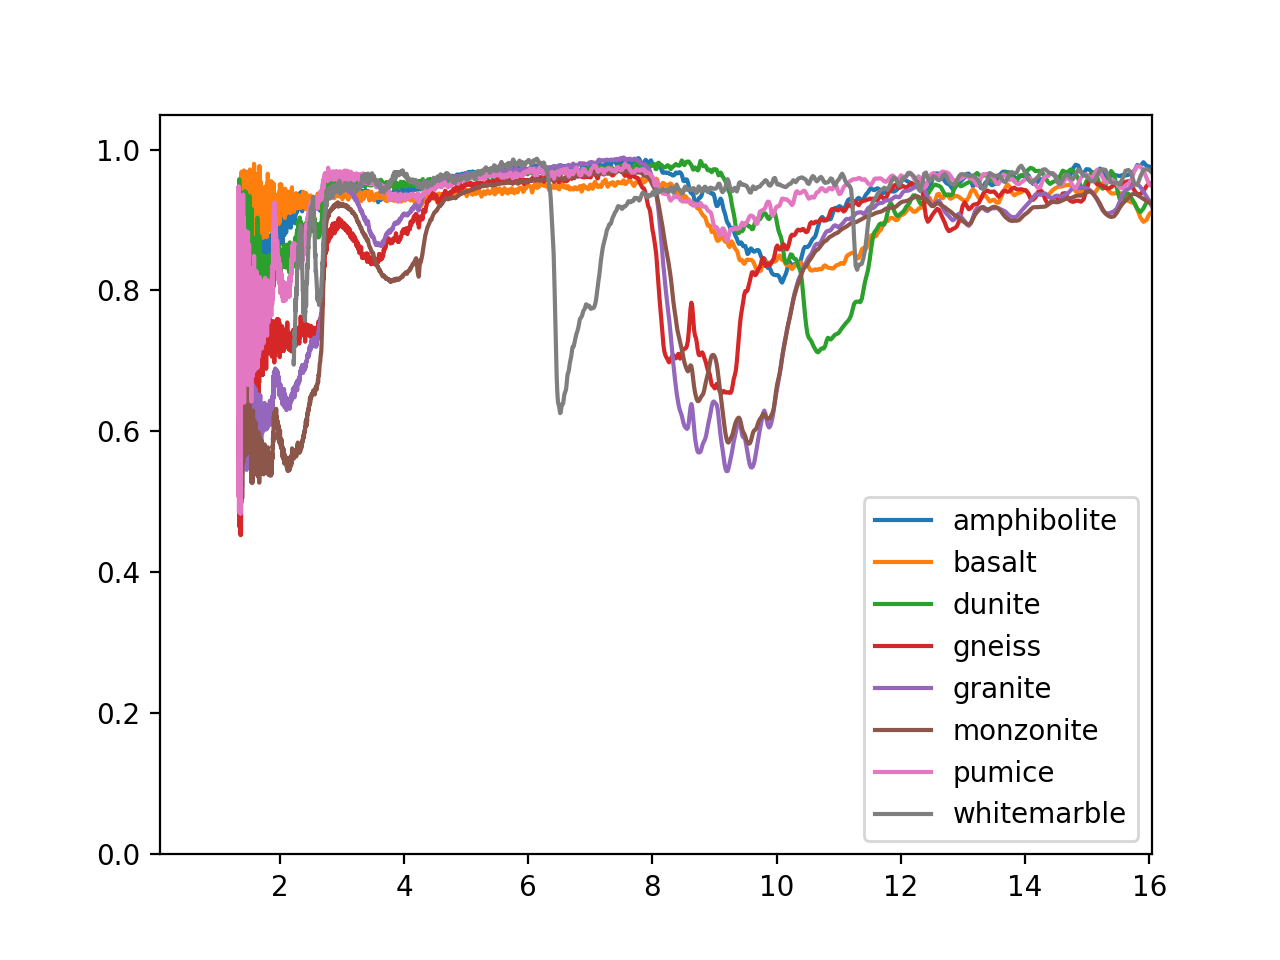

In [17]:
plt.figure()
plt.plot(wav_amphibolite, eps_amphibolite, label='amphibolite')
plt.plot(wav_basalt, eps_basalt, label='basalt')
plt.plot(wav_dunite, eps_dunite, label='dunite')
plt.plot(wav_gneiss, eps_gneiss, label='gneiss')
plt.plot(wav_granite, eps_granite, label='granite')
plt.plot(wav_monzonite, eps_monzonite, label='monzonite')
plt.plot(wav_pumice, eps_pumice, label='pumice')
plt.plot(wav_whitemarble, eps_whitemarble, label='whitemarble')
plt.legend()

### 4. Comparing a blackbody emission spectrum with the LHS 3844b Spitzer data

Let's do a simple blackbody test with LHS-3844b's planetary parameters. Assuming that the planet is emitting like a blackbody, and using eq. 10 from Hu et al. for flux:

$$\dfrac{F_p}{F_*} = \dfrac{\pi B_\lambda(T_{planet})(R_p/D)^2}{\pi B_\lambda(T_{star})(R_*/D)^2}$$
$$\dfrac{F_p}{F_*} = \dfrac{B_\lambda(T_{planet})R_p^2}{B_\lambda(T_{star})R_*^2}$$

In [3]:
# define a function that claculates blackbody radiance at a given wavelength or wavelength array, and a given temperature

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

In [8]:
# define planetary parameters for LHS 3844b using Kreidberg et al. (2019)

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained


# calcualte blackbody flux

wav = np.linspace(1,20, num=100)    # wavelength array in microns
spec = bb(wav*10**-6,T_dayside)*R_p**2/(bb(wav*10**-6, T_star)*R_star**2)

<IPython.core.display.Javascript object>


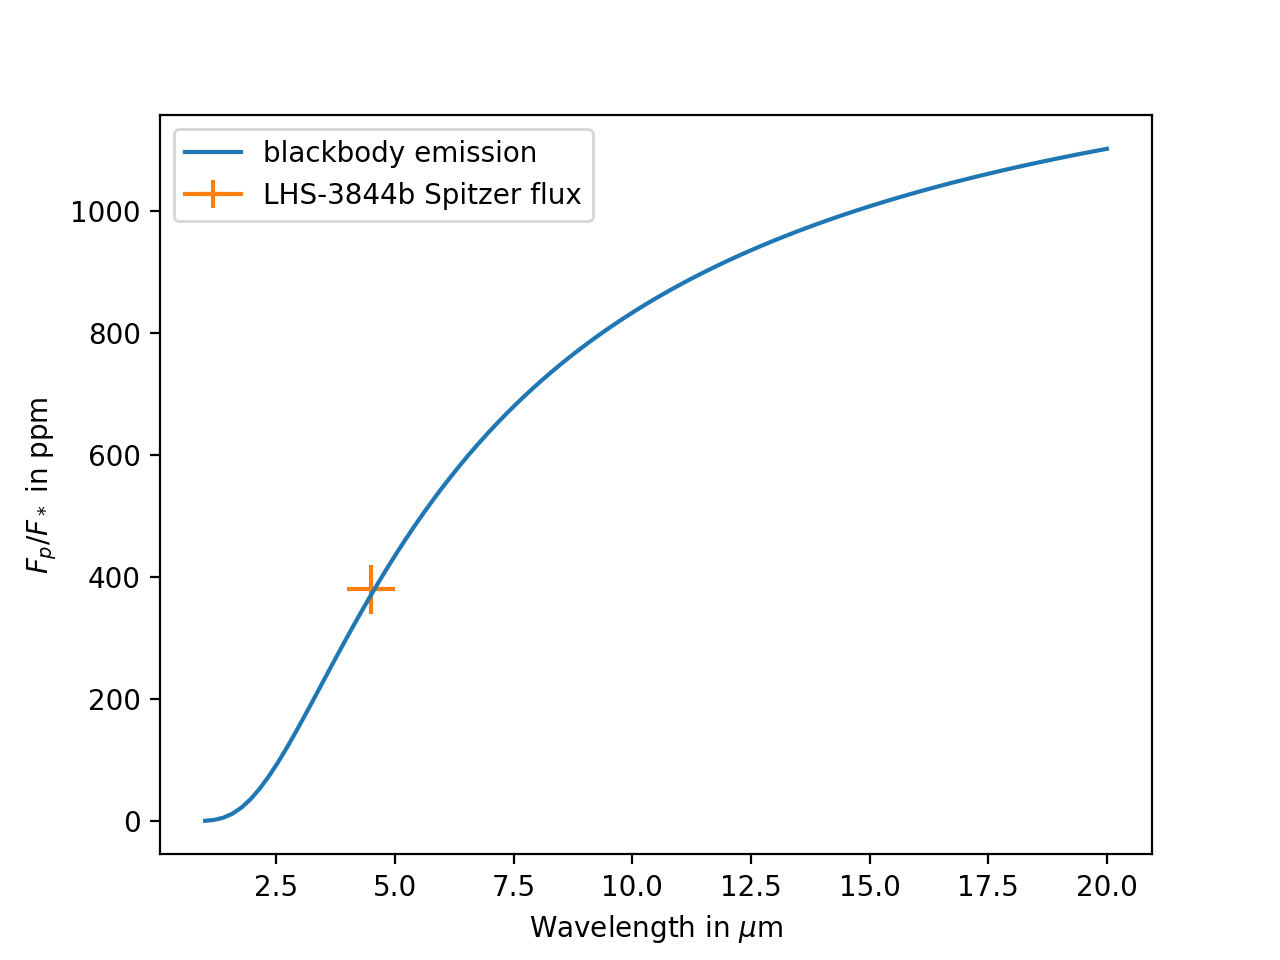

In [11]:
plt.plot(wav, spec*10**6, label='blackbody emission')
    
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

**Its a perfect match! This indicates that our planetary parameters are in the right ballpark. Also, this means that a planet emitting like a blackbody, without any assumptions of its surface composition, can also fit the sole Spitzer data point. Hence, to do better than this, we need data at different wavelengths, or spectrum, which JWST can provide.**

### 5. Using my flux code to generate candidate mineral spectra for LHS 3844b

In [4]:
# define a function to calculate F_p/F_* at a given wavelength, using eq. 1 from section 1 above. 
 

def fp_over_fstar(wav,R_p, D_p, eps, T_eq, T_star, R_star):
    # calculate the emission integral
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    integral = 0
    
    for theta in theta_array:
        for phi in phi_array:
            T = T_eq*(np.cos(theta)*np.cos(phi))**0.25
            B = bb(wav,T)
            integral += eps*B*np.cos(theta)**2*np.cos(phi)*dtheta*dphi
            
    return (R_p/D_p)**2*(1 - eps + integral/(np.pi*bb(wav,T_star)*(R_star/D_p)**2))    


# define the same function again but use numpy array operations instead of for-loops

def fp_over_fstar_alt(wav_array,R_p, D_p, eps_array, T_00, T_star, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*bb(wav,T_star)*(R_star/D_p)**2)) 
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

**Let's compare runtime of both functions**

In [29]:
eps = np.ones(100)    # assume a blackbody with emissivity=1 across all wavelengths
wav = np.linspace(1,6, num=100)    # wavelength array in microns

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_eq = 809.13    # equlibrium temperature in K
T_star = 3036    # stellar temperature in K
R_star = 0.19*6.957e+8    # stellar radius in meters

spec = np.full(100, np.nan)

In [30]:
%%timeit
for i in range(spec.size):
    spec[i] = fp_over_fstar(wav[i]*10**-6, R_p, D_p, eps[i], T_eq, T_star, R_star)

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


1 loop, best of 3: 16.1 s per loop


In [31]:
%%timeit
spec = fp_over_fstar_alt(wav*10**-6, R_p, D_p, eps, T_eq, T_star, R_star)

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


10 loops, best of 3: 103 ms per loop


**Good! The alternate function that avoids the nested for-loops is clearly superior**. We will proceed with the `fp_over_fstar_alt`...

#### Load Emily's emissivity data and calculate corresponding planetary flux spectra

In [4]:
eps_amphibolite = np.loadtxt('data_Emily/amphibolite.csv', delimiter=',')
wav_amphibolite, eps_amphibolite = eps_amphibolite[:,0][::-1], eps_amphibolite[:,1][::-1]

eps_basalt = np.loadtxt('data_Emily/basalt.csv', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt[:,0][::-1], eps_basalt[:,1][::-1]

eps_dunite = np.loadtxt('data_Emily/dunite.csv', delimiter=',')
wav_dunite, eps_dunite = eps_dunite[:,0][::-1], eps_dunite[:,1][::-1]

eps_gneiss = np.loadtxt('data_Emily/gneiss.csv', delimiter=',')
wav_gneiss, eps_gneiss = eps_gneiss[:,0][::-1], eps_gneiss[:,1][::-1]

eps_granite = np.loadtxt('data_Emily/granite.csv', delimiter=',')
wav_granite, eps_granite = eps_granite[:,0][::-1], eps_granite[:,1][::-1]

eps_monzonite = np.loadtxt('data_Emily/monzoniteporphyry.csv', delimiter=',')
wav_monzonite, eps_monzonite = eps_monzonite[:,0][::-1], eps_monzonite[:,1][::-1]

eps_pumice = np.loadtxt('data_Emily/pumice.csv', delimiter=',')
wav_pumice, eps_pumice = eps_pumice[:,0][::-1], eps_pumice[:,1][::-1]

eps_whitemarble = np.loadtxt('data_Emily/whitemarble.csv', delimiter=',')
wav_whitemarble, eps_whitemarble = eps_whitemarble[:,0][::-1], eps_whitemarble[:,1][::-1]

In [7]:
# calculate Fp/F_star for all these compositions 

# define planetary parameters for LHS 3844b using Kreidberg et al. (2019)

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K 
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained 

eps_list = [eps_amphibolite, eps_basalt, eps_dunite, eps_gneiss, eps_granite, eps_monzonite, eps_pumice, eps_whitemarble]
wav_list = [wav_amphibolite, wav_basalt, wav_dunite, wav_gneiss, wav_granite, wav_monzonite, wav_pumice, wav_whitemarble]
label_list = ['amphibolite', 'basalt', 'dunite', 'gneiss', 'granite', 'monzonite', 'pumice', 'whitemarble']

spec_list = []

for i in range(len(wav_list)):
    spec_list.append(fp_over_fstar_alt(wav_list[i]*10**-6, R_p, D_p, eps_list[i], T_dayside, T_star, R_star))
    print(label_list[i] + ' done')

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


amphibolite done
basalt done
dunite done
gneiss done
granite done
monzonite done
pumice done
whitemarble done


<IPython.core.display.Javascript object>


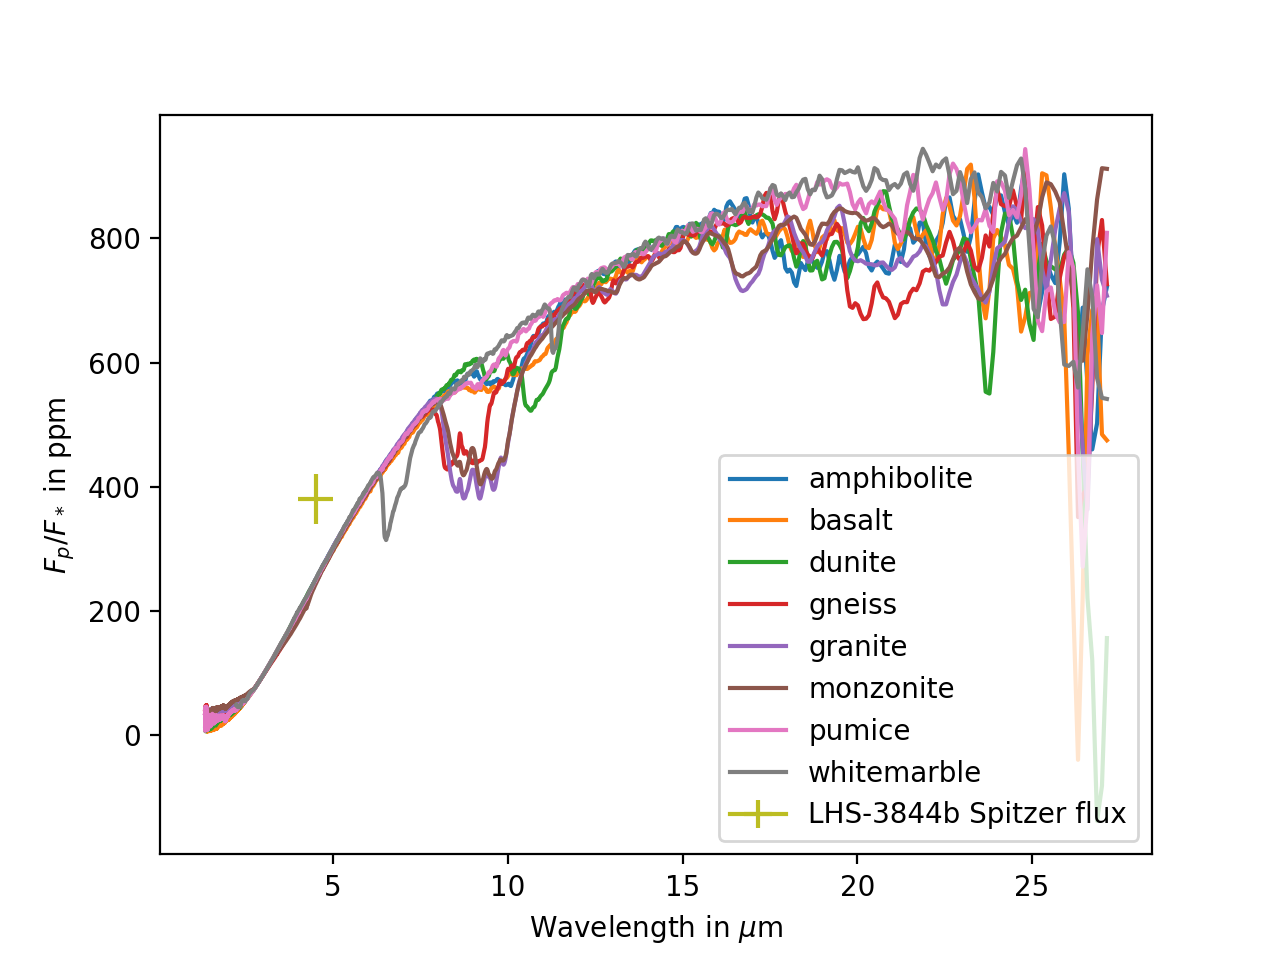

In [9]:
plt.figure()

for i in range(len(spec_list)):
    plt.plot(wav_list[i], spec_list[i]*10**6, label=label_list[i])
    
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Hmmmm. There is a discrepancy between the Spitzer point and the mineral spectra...

Does it also happen when one assumes uniform emissivity of 1?

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


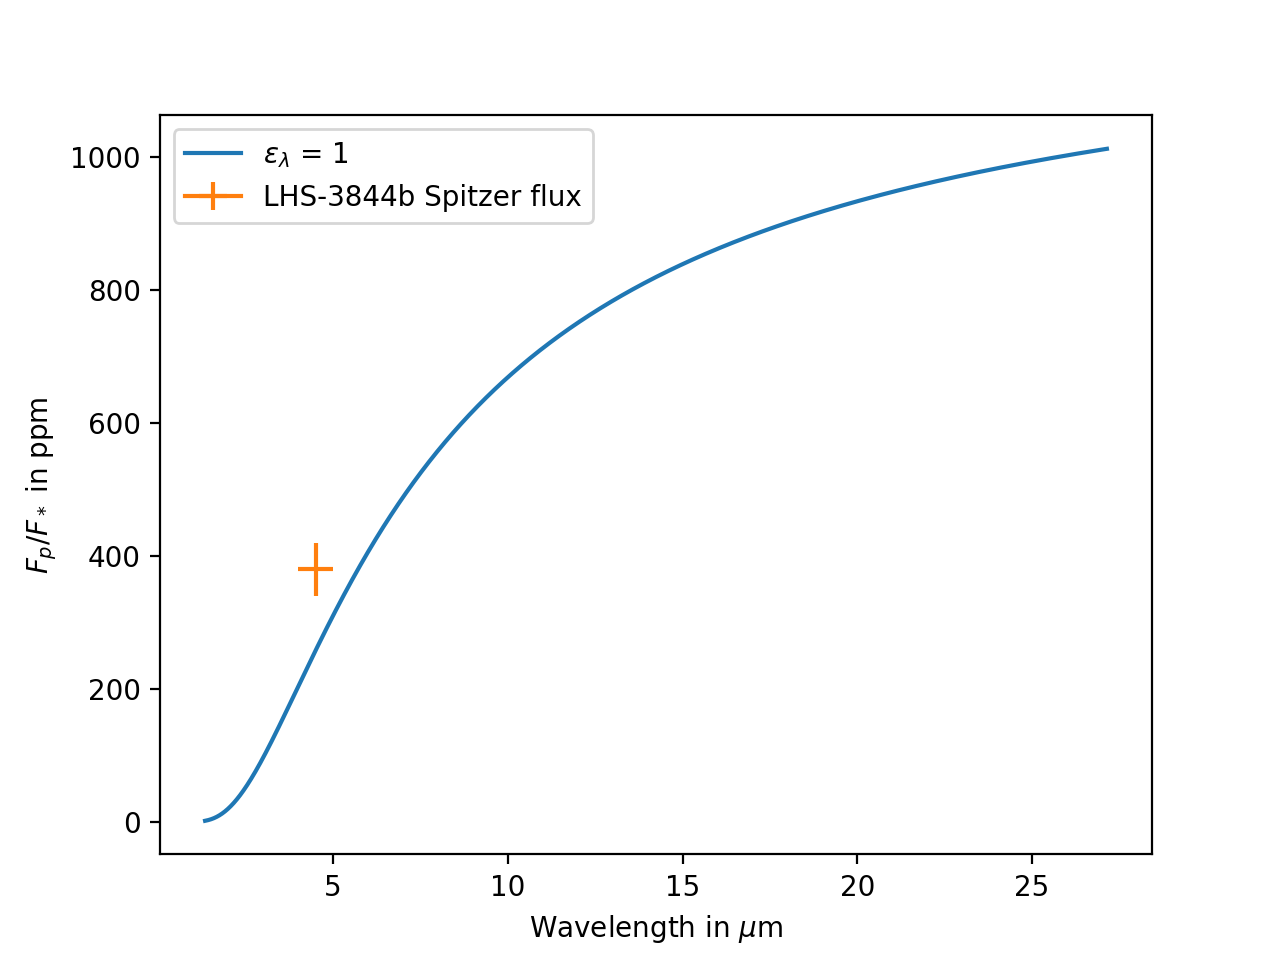

In [12]:
# calculate Fp/F_star for all these compositions 

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 

eps_constant = np.ones(wav_basalt.size)

spec = fp_over_fstar_alt(wav_basalt*10**-6, R_p, D_p, eps_constant, T_dayside, T_star, R_star)

plt.figure()

plt.plot(wav_basalt, spec*10**6, label='$\epsilon_\lambda$ = 1')    
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Okay, the discrepancy persists. We will need a multiplicative fudge factor to match the reflectance levels to the Spitzer data point.

<IPython.core.display.Javascript object>


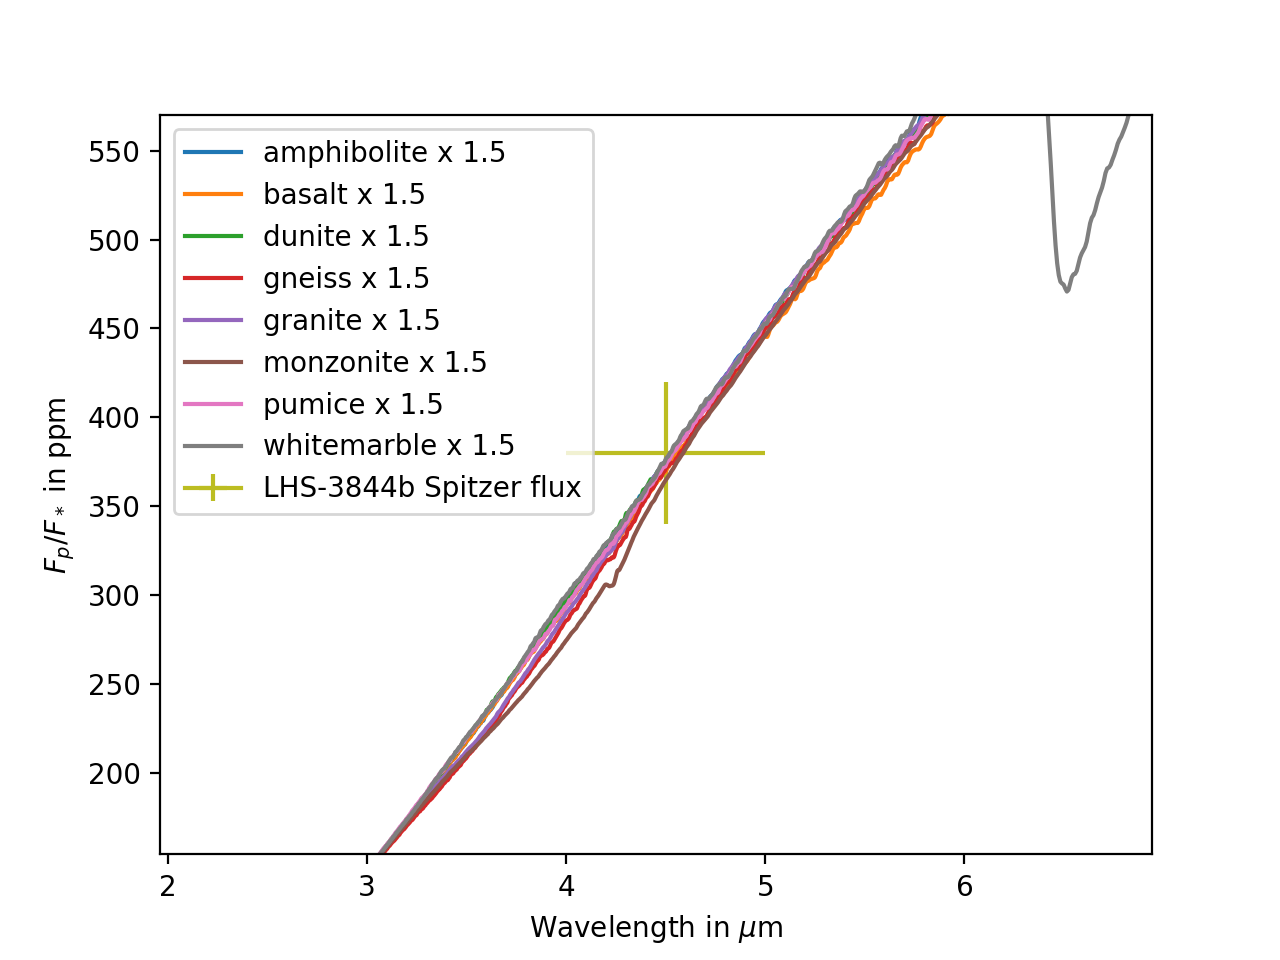

In [15]:
plt.figure()

fudge_factor = 1.5    # found using trial and error

for i in range(len(spec_list)):
    plt.plot(wav_list[i], fudge_factor*spec_list[i]*10**6, label=label_list[i]+' x '+ str(fudge_factor))
    
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

I suspect that the mineral spectra, as well as the blackbody spectrum, all have lower than expected values because the temperature in my calculation is decreases away from the substellar point. In section 3, the blackbody spectrum was matching the Spitzer data-point at 4.5 $\mu$m because we assumed a uniform temperature across the disk, rather than $T(cos(\theta)cos(\phi))^{1/4}$.

**Check what happens with uniform emissivity and uniform temperature ($T[\theta, \phi] = T_{00}$)**

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


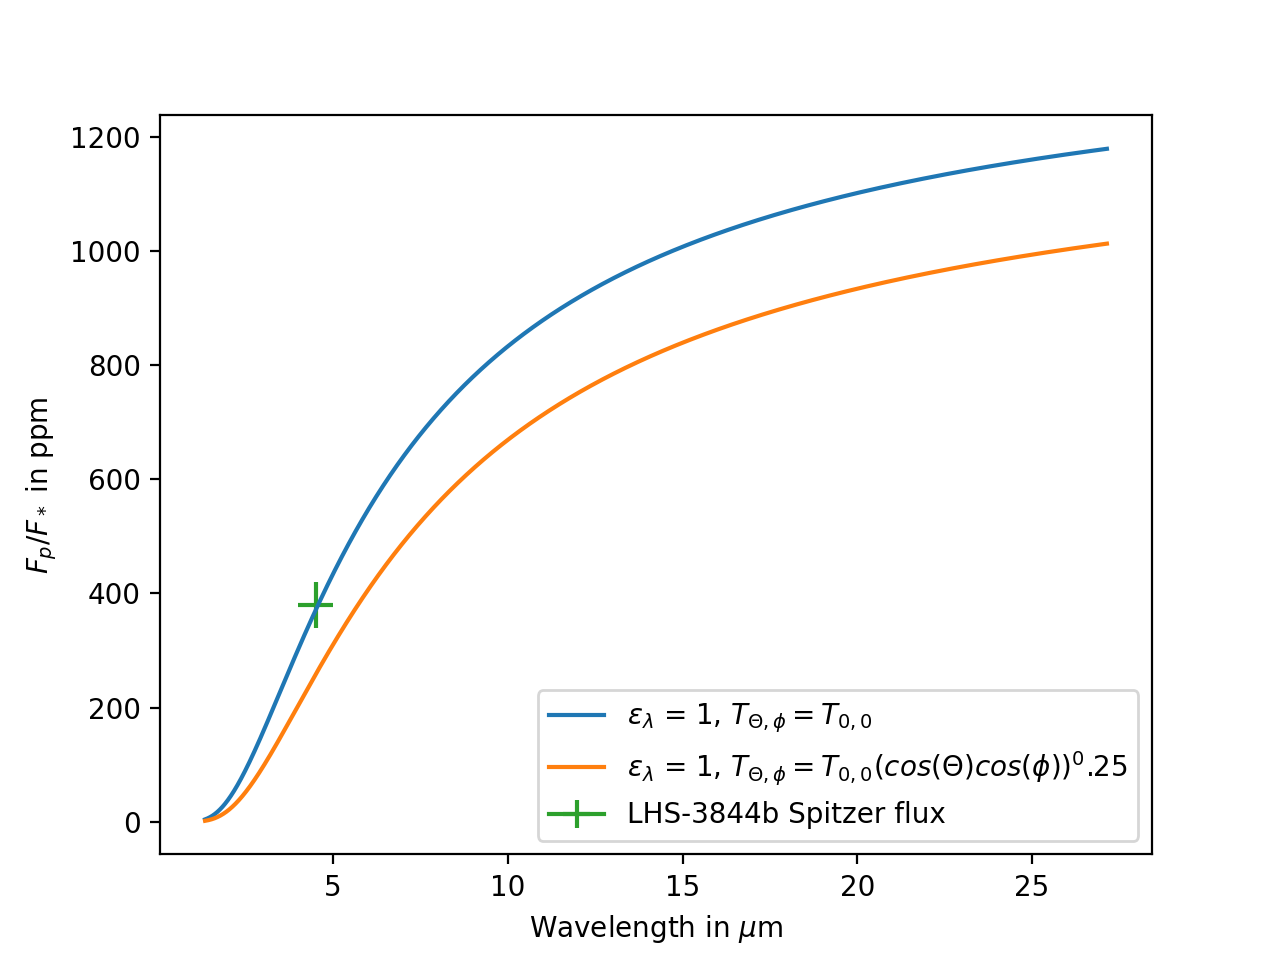

In [21]:
# calculate Fp/F_star for all these compositions 

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 

eps_constant = np.ones(wav_basalt.size)

spec_constant_T = fp_over_fstar_alt(wav_basalt*10**-6, R_p, D_p, eps_constant, T_dayside, T_star, R_star, constant_T=True)
spec_var_T = fp_over_fstar_alt(wav_basalt*10**-6, R_p, D_p, eps_constant, T_dayside, T_star, R_star)

plt.figure()

plt.plot(wav_basalt, spec_constant_T*10**6, label='$\epsilon_\lambda$ = 1, $T_{\Theta,\phi} = T_{0,0}$')  
plt.plot(wav_basalt, spec_var_T*10**6, label='$\epsilon_\lambda$ = 1, $T_{\Theta,\phi} = T_{0,0}(cos(\Theta)cos(\phi))^0.25$')  
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Okay, so the constant temperature does make a difference! Does this also work with mineral spectra?

C:\Users\ishan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


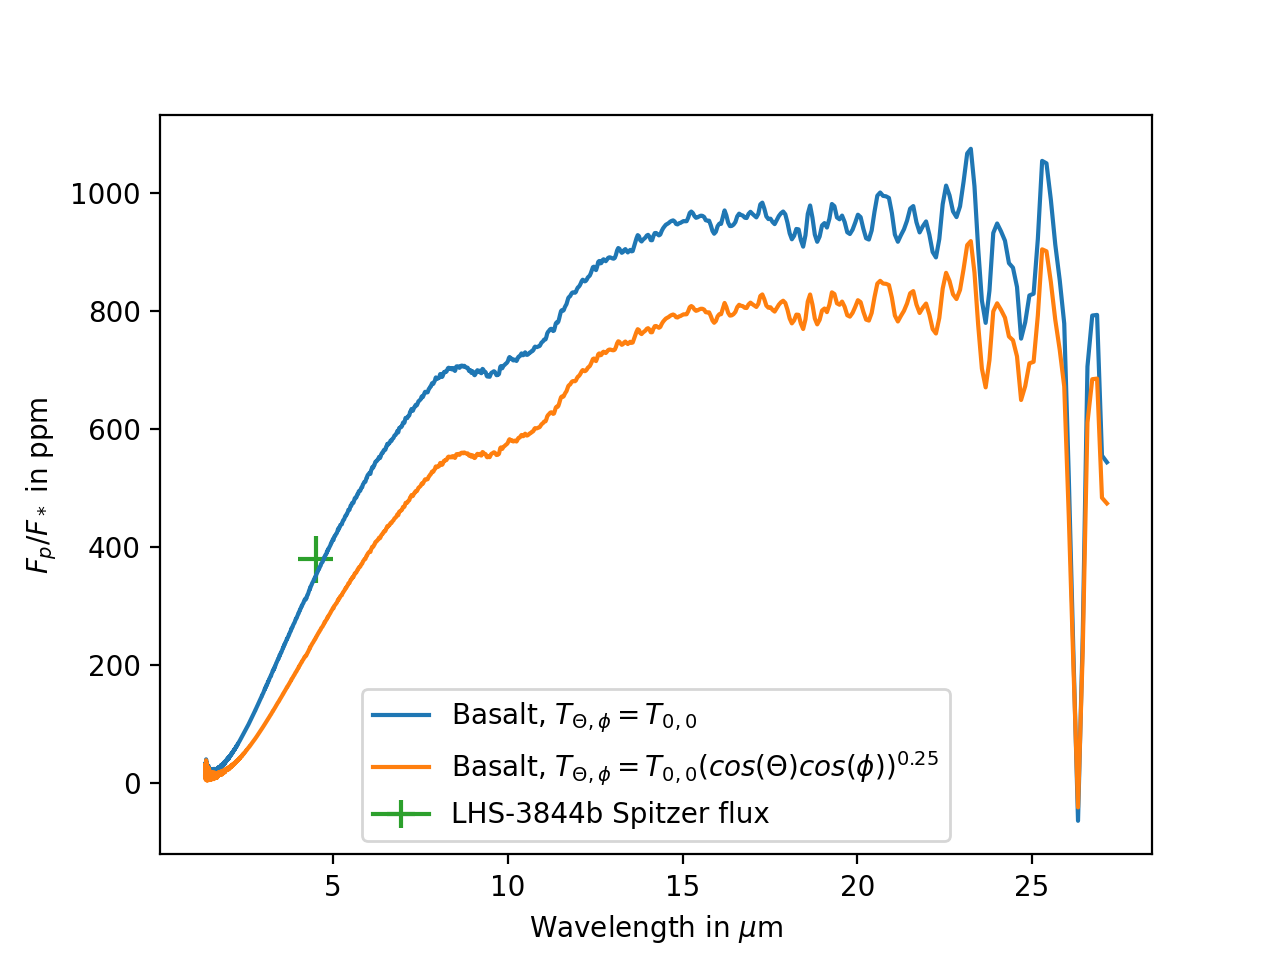

In [23]:
# calculate Fp/F_star for all these compositions 

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 

spec_constant_T = fp_over_fstar_alt(wav_basalt*10**-6, R_p, D_p, eps_basalt, T_dayside, T_star, R_star, constant_T=True)
spec_var_T = fp_over_fstar_alt(wav_basalt*10**-6, R_p, D_p, eps_basalt, T_dayside, T_star, R_star)

plt.figure()

plt.plot(wav_basalt, spec_constant_T*10**6, label='Basalt, $T_{\Theta,\phi} = T_{0,0}$')  
plt.plot(wav_basalt, spec_var_T*10**6, label='Basalt, $T_{\Theta,\phi} = T_{0,0}(cos(\Theta)cos(\phi))^{0.25}$')  
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Okay this is definitely better! Produce the plot with all minerals, assuming uniform temperature

In [24]:
# calculate Fp/F_star for all these compositions 

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 

eps_list = [eps_amphibolite, eps_basalt, eps_dunite, eps_gneiss, eps_granite, eps_monzonite, eps_pumice, eps_whitemarble]
wav_list = [wav_amphibolite, wav_basalt, wav_dunite, wav_gneiss, wav_granite, wav_monzonite, wav_pumice, wav_whitemarble]
label_list = ['amphibolite', 'basalt', 'dunite', 'gneiss', 'granite', 'monzonite', 'pumice', 'whitemarble']

spec_list = []

for i in range(len(wav_list)):
    spec_list.append(fp_over_fstar_alt(wav_list[i]*10**-6, R_p, D_p, eps_list[i], T_dayside, T_star, R_star, constant_T=True))
    print(label_list[i] + ' done')

amphibolite done
basalt done
dunite done
gneiss done
granite done
monzonite done
pumice done
whitemarble done


<IPython.core.display.Javascript object>


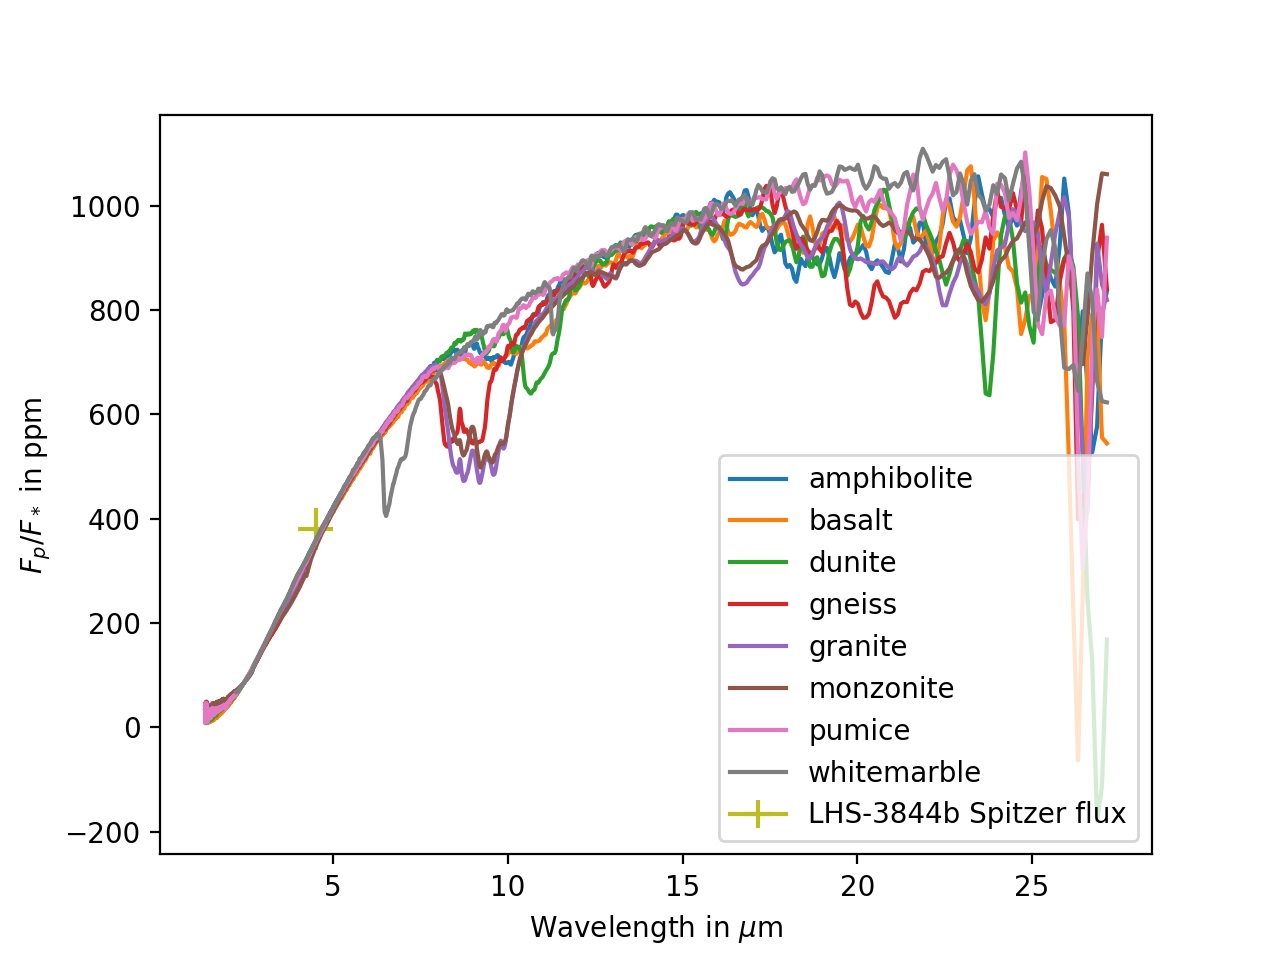

In [28]:
plt.figure()

for i in range(len(spec_list)):
    plt.plot(wav_list[i], spec_list[i]*10**6, label=label_list[i])
    
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
#plt.title('Assuming $T_{\Theta,\phi} = T_{0,0} = 1040 K$')
plt.legend()

#### So, we are able to get mineral spectra that match the flux level of the Spitzer data-point at 4.5 $\mu$m, but only after the uniform temperature assumption. For now though, this patchwork serves our purpose of comparing planetary flux for different mineral compositions. 

### Try different temparatures, but keep the Cowan temperature function.

In Figure 7 of Hu et al., there are substellar temperature listed for different mineral compositions. Out of all of them, basalt and granite seem to be the common one. Try evaluating the spectra with the temperature listed in Hu et al., **for Kepler 20-f** and compare with Figure 7 of Hu et al.

In [13]:
# load digitized data from Fig 7 of Hu et al. 

data_basalt = np.loadtxt('Resources/hu_fig7_basaltic.csv', delimiter=',')
wav_basalt_hu, spec_basalt_hu = data_basalt[:,0], data_basalt[:,1]

data_granite = np.loadtxt('Resources/hu_fig7_granitoid.csv', delimiter=',')
wav_granite_hu, spec_granite_hu = data_granite[:,0], data_granite[:,1]

In [7]:
# calculate Fp/F_star for all these compositions 

# define planetary parameters for Kepler-20f using Fressin et al. (2012)

R_p = 1.03*6378.137*1000.   # planetary radius in meters
T_star = 5466    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.01002    # value obtained from Kreidberg et al.
D_p = 25.15*R_star    # planet orbital distance in meters (assuming 0 eccentricity)

T_dayside_list = [1077, 1018]    # dayside brightness temperature in K, obtained from Figure 7 of Hu et al. 
eps_list = [eps_basalt, eps_granite]
wav_list = [wav_basalt, wav_granite]
label_list = ['basalt', 'granite']

spec_list = []

for i in range(len(wav_list)):
    spec_list.append(fp_over_fstar_alt(wav_list[i]*10**-6, R_p, D_p, eps_list[i], T_dayside_list[i], T_star, R_star))
    print(label_list[i] + ' done')

<ipython-input-3-535f1738ee1f>:12: RuntimeWarning: overflow encountered in exp
  intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )


basalt done
granite done


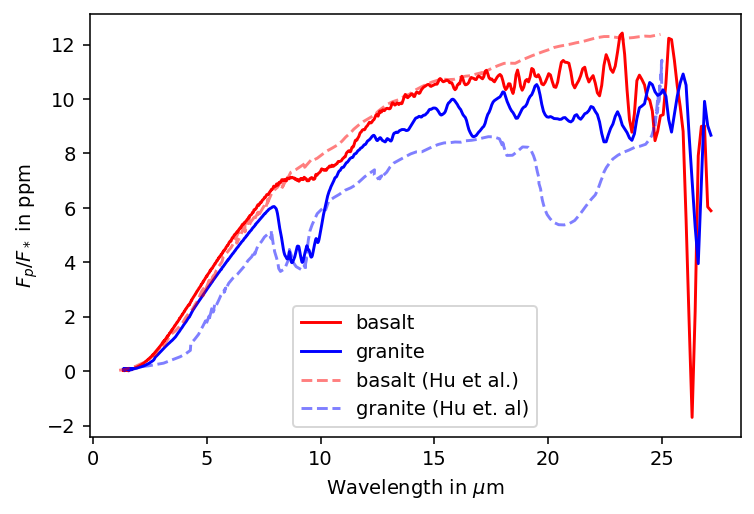

In [19]:
plt.figure()

color_list = ['red', 'blue']

for i in range(len(spec_list)):
    plt.plot(wav_list[i], spec_list[i]*10**6, label=label_list[i], color=color_list[i])

plt.plot(wav_basalt_hu, spec_basalt_hu, label='basalt (Hu et al.)', ls='--', color = color_list[0], alpha=0.5)
plt.plot(wav_granite_hu, spec_granite_hu, label='granite (Hu et. al)', ls='--', color = color_list[1], alpha=0.5)

plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()